# Simulation for Potts model
- No interaction (infinite temperature)
- No field
- Preference for low number of colors

- $N$ vertices
- $P(\sigma) = \frac{1}{N^N} \exp((N-n(\sigma))\gamma$), where $n(\sigma) = \text{# of colors used in } \sigma$

- We only consider the interaction on the largest hyperedge on lattice $\Lambda$, where $|\Lambda| = N$
- We assign $\eta_{\Lambda} \in \mathcal{P}(q^N)$ which is in one-to-one correspondence with $\{1,2,...,N\}$
- Each of these corresponds to an energy level in $\{(N-1)\gamma, (N-2)\gamma, ..., 0\}$

- Take $ \upsilon_k =  \frac{e^{((N-k)\gamma)} - e^{((N-k-1)\gamma)}}{e^{((N-1)\gamma)}} $

- Joint distribution
- $Q(\eta, \sigma) = \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} $

- Marginals
- $Q(\eta | \sigma) =  \frac { \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} }{P(\sigma)}$
- $Q(\sigma | \eta) = \frac{1}{|\{\sigma:  \eta(\sigma) \leq \eta(\Lambda)\}|} $

In [1]:
# Initial code from https://rajeshrinet.github.io/blog/2014/ising-model/

import numpy as np 
from numpy.random import rand
from scipy.special import binom

def initial_config(N, no_colors=2):   
    ''' Generate a random color/spin configuration for initialization'''
    state = np.random.randint(no_colors, size=(N,N))
    return state


def mc_move(config, eta_prob, parts, parts_prob, N, q):
    '''Monte Carlo move using generalized SW algorithm '''
    # Assign eta to each hyperedge
    eta = assign_etas(config, eta_prob, q)
#     print('assigned eta:', eta)
    # Assign labels to each site
    config = assign_labels(eta, parts, parts_prob, N, q)
#     print('assigned configuration:\n', config)
    return  config


def number_of_colors (config):
    '''Number of colors used in the given confuration of labels'''
    return len(np.unique(config))


def avg_sites_per_color (config):
    '''Average number of sites each present color has in the configuration'''
    unq = np.unique(config)
    return config.shape[0]*config.shape[1]/len(unq)


def calc_energy(config):
    '''Energy of a given configuration'''
    energy = 0
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i,j]
            nb = config[(i+1)%N, j] + config[i,(j+1)%N] + config[(i-1)%N, j] + config[i,(j-1)%N]
            energy += -nb*S
    return energy/4.


def calc_mag(config):
    '''Magnetization of a given configuration'''
    mag = np.sum(config)
    return mag


def prob_eta(gamma, q, k):
    '''Probability of the eta corresponding to a certain number of colors'''
    if k < q:
        return ( np.exp((q-k)*gamma) - np.exp((q-k-1)*gamma) ) / np.exp((q-1)*gamma)
    elif k == q:
        return 1 / np.exp(gamma*(q-1))

    
def lengths_of_partition(partition):
    '''Lengths of equal subtrings in a partition'''
    lengths = []
    cnt = 0
    curr = partition[0]
    for i in range(len(partition)):
        if partition[i] == curr:
            cnt += 1
            if i == len(partition)-1:
                lengths.append(cnt)
        else:
            lengths.append(cnt)
            cnt = 1
            curr = partition[i]
            if i == len(partition)-1:
                lengths.append(cnt)
    return tuple(lengths)


def multinomial(params):
    if len(params) == 1:
        return 1
#     print (sum(params), params[0])
    return binom(sum(params), params[0]) * multinomial(params[1:])


def prob_of_partition(partition, no_sites, no_colors):
    '''Probability of a given partition'''
    p = partition
    l = ll = lengths_of_partition(p)
    if sum(l) < no_colors: ll = l + (no_colors-sum(l),)
    m1 = multinomial(ll)
    m2 = multinomial(p)
#     print(p, m1, m2, m1*m2)
#     print(l)
#     print(ll)
#     print()
    return m1*m2

    
def assign_etas(config, prob, q):
    '''Assign a number of colors that is at least the current number of colors, with correct probabilities'''
    current_k = number_of_colors(config)
#     print('current no. of colors:', current_k)
    p = prob[current_k-1:]
#     print('probabilities for no. of colors:', p)
    p = p / p.sum()
# #     print('normalized:', p)
    return np.random.choice((np.arange(current_k, q+1)), p=p)


def assign_labels(max_colors, parts, prob, N, q):
    '''Assign a color configuration that has at most the corresponding number of eta'''
    # Brute force version
#     config = initial_config(N, q)
#     while number_of_colors(config) > max_colors:
#         config = initial_config(N, q)
#     return config
    
    idx_max_color = len(parts)                  # index of first occurence of a partition with more than max_colors
    for i in range(len(parts)):
        if len(parts[i]) > max_colors:
            idx_max_color = i
            break
    
#     print('max colors:', max_colors)
#     print('partitions:', parts)
#     print('idx of partition with max color:', idx_max_color)
    p = np.array(prob[:idx_max_color])
#     print('probabilities for partitions:', p)
    p = p / p.sum()
#     print('normalized:', p)
    if idx_max_color > 1: chosen_part = np.random.choice(parts[:idx_max_color], p=p)
    else: chosen_part = parts[0]
#     print('chosen partition:', chosen_part)
        
    # Choose the colors to be used
    chosen_colors = np.random.choice(q, len(chosen_part), replace=False)
#     print('chosen colors:', chosen_colors)

    # Choose a random permutation of the given word
    color_arr = []
    for i in range(len(chosen_part)): color_arr += [chosen_colors[i]]*chosen_part[i]
    color_arr = np.array(color_arr)
#     print('color array:\n', color_arr)
    config = np.random.permutation(color_arr).reshape(N,N)
    return config

In [2]:
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr

def init_partitions(N, q):
    session = WolframLanguageSession()
    parts = session.evaluate(wl.IntegerPartitions(N*N,q))
    print(parts)

    sorted_p = tuple(sorted(parts, key=lambda x: len(x)))
    print(sorted_p)

    part_prob = tuple([prob_of_partition(p, N*N, q) for p in sorted_p])
    print(part_prob)
    print(sum(part_prob), q**(N*N))
    print(q**(N*N)-sum(part_prob))
    part_prob = tuple(part_prob / sum(part_prob))
    print(part_prob)
    return sorted_p, part_prob

    session.terminate()

## Experiment routine

In [3]:
# Small experiment

N, q = 3, 4
sorted_p, part_prob = init_partitions(N, q)
gamma = 2.5
print('Initialization done')
print()

eta_prob = np.zeros(q)
for j in range(q):
    eta_prob[j] = prob_eta(gamma,q,j+1)
print('eta probabilities:', eta_prob)

config = initial_config(N,q)
# config = np.array([[0,0],[0,0]])
print('initial config:\n', config)
config = mc_move(config, eta_prob, sorted_p, part_prob, N, q)

((9,), (8, 1), (7, 2), (7, 1, 1), (6, 3), (6, 2, 1), (6, 1, 1, 1), (5, 4), (5, 3, 1), (5, 2, 2), (5, 2, 1, 1), (4, 4, 1), (4, 3, 2), (4, 3, 1, 1), (4, 2, 2, 1), (3, 3, 3), (3, 3, 2, 1), (3, 2, 2, 2))
((9,), (8, 1), (7, 2), (6, 3), (5, 4), (7, 1, 1), (6, 2, 1), (5, 3, 1), (5, 2, 2), (4, 4, 1), (4, 3, 2), (3, 3, 3), (6, 1, 1, 1), (5, 2, 1, 1), (4, 3, 1, 1), (4, 2, 2, 1), (3, 3, 2, 1), (3, 2, 2, 2))
(4.0, 108.0, 432.0, 1008.0, 1512.0, 864.0, 6048.0, 12096.0, 9072.0, 7560.0, 30240.0, 6720.0, 2016.0, 18144.0, 30240.0, 45360.0, 60480.0, 30240.0)
262144.0 262144
0.0
(1.52587890625e-05, 0.0004119873046875, 0.00164794921875, 0.00384521484375, 0.005767822265625, 0.0032958984375, 0.0230712890625, 0.046142578125, 0.03460693359375, 0.028839111328125, 0.1153564453125, 0.025634765625, 0.0076904296875, 0.0692138671875, 0.1153564453125, 0.17303466796875, 0.230712890625, 0.1153564453125)
Initialization done

eta probabilities: [9.17915001e-01 7.53470516e-02 6.18486263e-03 5.53084370e-04]
initial config:

In [4]:
## change these parameters for a smaller (faster) simulation 
ng      = 36          #  number of gammas to try out
eq_steps = 5005       #  number of MC sweeps for equilibration
mc_steps = 5005       #  number of MC sweeps for calculation

In [5]:
import matplotlib.pyplot as plt

def experiment_for_N (N,q):
    '''Run simulation for different gammas given a lattice size
       N = size of the lattice, N x N
       q = number of colors
    '''
    sorted_p, part_prob = init_partitions(N,q)
    print('Initialization done')
    print()
    gamma = np.linspace(0, 3.5, ng);
    eta_probs = np.zeros((ng, q))

    for i in range(ng):
        for j in range(q):
            eta_probs[i][j] = prob_eta(gamma[i],q,j+1)
    
    avg_c, avg_s_c = np.zeros(ng), np.zeros(ng)

    for g in range(ng):
        tot_c = tot_s_c = 0
        config = initial_config(N,q)
        eta_prob = eta_probs[g]
        print(g, ' - gamma:', gamma[g])
        print(eta_prob)

        for i in range(eq_steps):           # equilibrate
            config = mc_move(config, eta_prob, sorted_p, part_prob, N, q) # Monte Carlo moves

        for i in range(mc_steps):
            config = mc_move(config, eta_prob, sorted_p, part_prob, N, q)           
            no_cols = number_of_colors(config)       # calculate the energy
            no_sites = avg_sites_per_color(config)         # calculate the magnetisation

            tot_c = tot_c + no_cols
            tot_s_c = tot_s_c + no_sites

            if i%1000==0: print (i+1, tot_c/(i+1), tot_s_c/(i+1))
        
        print(config)
        avg_c[g] = tot_c / (mc_steps)
        avg_s_c[g] = tot_s_c / (mc_steps)
        print(avg_c[g], avg_s_c[g])
        print()
        
    f = plt.figure(figsize=(18, 10)); # plot the calculated values    

    sp =  f.add_subplot(2, 1, 1 );
    plt.scatter(gamma, avg_c, s=50, marker='o', color='IndianRed')
    plt.xlabel("Gamma (g)", fontsize=20);
    plt.ylabel("Avg. no. of colors ", fontsize=20);         plt.axis('tight');

    sp =  f.add_subplot(2, 1, 2 );
    plt.scatter(gamma, avg_s_c, s=50, marker='o', color='RoyalBlue')
    plt.xlabel("Gamma (g)", fontsize=20); 
    plt.ylabel("Avg. sites per color ", fontsize=20);   plt.axis('tight');
    
    plt.show()

((4,), (3, 1), (2, 2), (2, 1, 1), (1, 1, 1, 1))
((4,), (3, 1), (2, 2), (2, 1, 1), (1, 1, 1, 1))
(4.0, 48.0, 36.0, 144.0, 24.0)
256.0 256
0.0
(0.015625, 0.1875, 0.140625, 0.5625, 0.09375)
Initialization done

0  - gamma: 0.0
[0. 0. 0. 1.]
1 3.0 1.3333333333333333
1001 2.7292707292707292 1.5687645687645595
2001 2.758120939530235 1.5475595535565738
3001 2.7564145284905033 1.548261690547607
4001 2.7458135466133466 1.5536115971006914
5001 2.7418516296740654 1.5558221688994927
[[0 1]
 [1 3]]
2.7416583416583418 1.555910755910695

1  - gamma: 0.1
[0.09516258 0.08610666 0.07791253 0.74081822]
1 2.0 2.0
1001 2.7122877122877123 1.5744255744255664
2001 2.7371314342828588 1.5592203898051153
3001 2.715761412862379 1.571254026435639
4001 2.716070982254436 1.570690660668128
5001 2.7150569886022797 1.573085382923351
[[3 0]
 [1 1]]
2.7152847152847155 1.5728937728937085

2  - gamma: 0.2
[0.18126925 0.14841071 0.12150841 0.54881164]
1 3.0 1.3333333333333333
1001 2.6853146853146854 1.6107226107226014
2001 

1 2.0 2.0
1001 1.8941058941058941 2.401598401598402
2001 1.847576211894053 2.479926703315013
3001 1.8487170943018993 2.473619904476277
4001 1.8457885528617846 2.480546530034161
5001 1.8432313537292542 2.4786376058121844
[[2 2]
 [2 2]]
1.8425574425574425 2.4798534798534937

24  - gamma: 2.4000000000000004
[9.09282047e-01 8.24882062e-02 7.48316124e-03 7.46585808e-04]
1 3.0 1.3333333333333333
1001 1.864135864135864 2.4512154512154503
2001 1.793103448275862 2.5563884724304504
3001 1.7757414195268244 2.5819171387315247
4001 1.7933016745813546 2.544447221527954
5001 1.795640871825635 2.535759514763726
[[3 3]
 [2 2]]
1.7962037962037962 2.5350649350649475

25  - gamma: 2.5
[9.17915001e-01 7.53470516e-02 6.18486263e-03 5.53084370e-04]
1 2.0 2.0
1001 1.7632367632367631 2.5561105561105557
2001 1.7586206896551724 2.5720473096784917
3001 1.76541152949017 2.5575919138065006
4001 1.770307423144214 2.55269515954345
5001 1.77124575084983 2.5532893421315848
[[1 1]
 [2 2]]
1.7714285714285714 2.5528471528

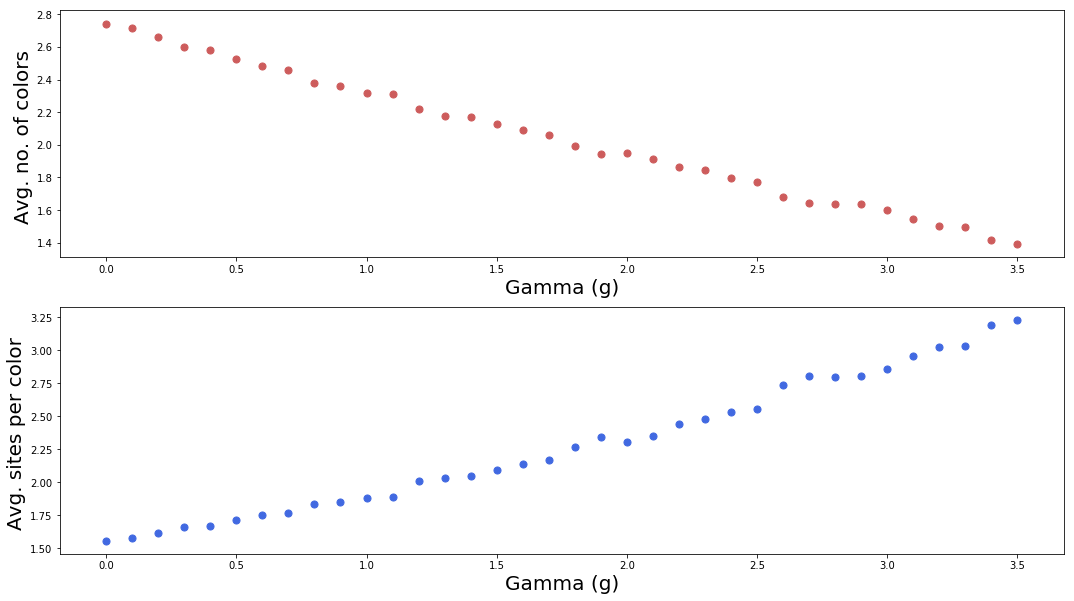

In [6]:
experiment_for_N (2,4) # Non-brute force version

((25,), (24, 1), (23, 2), (23, 1, 1), (22, 3), (22, 2, 1), (22, 1, 1, 1), (21, 4), (21, 3, 1), (21, 2, 2), (21, 2, 1, 1), (21, 1, 1, 1, 1), (20, 5), (20, 4, 1), (20, 3, 2), (20, 3, 1, 1), (20, 2, 2, 1), (20, 2, 1, 1, 1), (20, 1, 1, 1, 1, 1), (19, 6), (19, 5, 1), (19, 4, 2), (19, 4, 1, 1), (19, 3, 3), (19, 3, 2, 1), (19, 3, 1, 1, 1), (19, 2, 2, 2), (19, 2, 2, 1, 1), (19, 2, 1, 1, 1, 1), (19, 1, 1, 1, 1, 1, 1), (18, 7), (18, 6, 1), (18, 5, 2), (18, 5, 1, 1), (18, 4, 3), (18, 4, 2, 1), (18, 4, 1, 1, 1), (18, 3, 3, 1), (18, 3, 2, 2), (18, 3, 2, 1, 1), (18, 3, 1, 1, 1, 1), (18, 2, 2, 2, 1), (18, 2, 2, 1, 1, 1), (18, 2, 1, 1, 1, 1, 1), (18, 1, 1, 1, 1, 1, 1, 1), (17, 8), (17, 7, 1), (17, 6, 2), (17, 6, 1, 1), (17, 5, 3), (17, 5, 2, 1), (17, 5, 1, 1, 1), (17, 4, 4), (17, 4, 3, 1), (17, 4, 2, 2), (17, 4, 2, 1, 1), (17, 4, 1, 1, 1, 1), (17, 3, 3, 2), (17, 3, 3, 1, 1), (17, 3, 2, 2, 1), (17, 3, 2, 1, 1, 1), (17, 3, 1, 1, 1, 1, 1), (17, 2, 2, 2, 2), (17, 2, 2, 2, 1, 1), (17, 2, 2, 1, 1, 1, 1), (1

1 16.0 1.5625
1001 16.01098901098901 1.5769509490620108
2001 15.954022988505747 1.5826086802856436
3001 15.997000999666778 1.5782321378746489
4001 16.000249937515623 1.5779655834761446
5001 15.995400919816037 1.5784271190498296
[[ 1 15 14 15  0]
 [ 9 13 22 15 12]
 [10 17  1 24  4]
 [ 0 11 17 10 13]
 [19  6 13  1  7]]
15.995404595404596 1.5784168386154163

1  - gamma: 0.1
[0.09516258 0.08610666 0.07791253 0.07049817 0.06378939 0.05771902
 0.05222633 0.04725634 0.0427593  0.03869022 0.03500836 0.03167687
 0.02866242 0.02593483 0.0234668  0.02123364 0.01921299 0.01738464
 0.01573027 0.01423334 0.01287885 0.01165327 0.01054431 0.00954089
 0.09071795]
1 18.0 1.3888888888888888
1001 15.666333666333667 1.612156236104276
2001 15.741129435282359 1.6036840762940254
3001 15.719760079973343 1.6063477002967634
4001 15.713071732066982 1.6067534435245616
5001 15.719656068786243 1.6061449287600167
[[20 19 13 23 20]
 [21 24 15 15  1]
 [15 22 19 14  5]
 [21 12 16 22  2]
 [ 0 12 22 12 20]]
15.71908091908

2001 13.331334332833583 1.9025359359401157
3001 13.31022992335888 1.904472366982396
4001 13.282679330167458 1.9089306547974083
5001 13.268946210757848 1.9109441609661173
[[20 12  8  7 17]
 [22  7 20 22  0]
 [23  3  7 20 10]
 [19 23 20 17  7]
 [ 3  0 17 13  7]]
13.268531468531469 1.9109904509224795

12  - gamma: 1.2000000000000002
[6.98805788e-01 2.10476259e-01 6.33942308e-02 1.90939754e-02
 5.75099487e-03 1.73216637e-03 5.21718484e-04 1.57138588e-04
 4.73292331e-05 1.42552911e-05 4.29361116e-06 1.29321083e-06
 3.89507616e-07 1.17317440e-07 3.53353337e-08 1.06427980e-08
 3.20554916e-09 9.65492852e-10 2.90800859e-10 8.75875354e-11
 2.63808587e-11 7.94576195e-12 2.39321751e-12 7.20823261e-13
 3.10684024e-13]
1 13.0 1.9230769230769231
1001 13.234765234765234 1.910633507400699
2001 13.07296351824088 1.9373885367359531
3001 13.049316894368545 1.9408290653108968
4001 13.06173456635841 1.9388447226616852
5001 13.058588282343532 1.9401818810429967
[[20  6  2 16 20]
 [20 11 24 16  6]
 [24  7  7 

1 11.0 2.272727272727273
1001 10.815184815184816 2.3463537655595825
2001 10.69215392303848 2.380022075486864
3001 10.812729090303232 2.3524163412950174
4001 10.85153711572107 2.344550791345335
5001 10.921615676864628 2.328917860561558
[[14 19  1  2 10]
 [17 24  0  2  7]
 [14  1 19  0  8]
 [14  8  8  0  7]
 [ 1  8 15 24 14]]
10.921678321678321 2.328872952998854

23  - gamma: 2.3000000000000003
[8.99741156e-01 9.02070080e-02 9.04405032e-03 9.06746027e-04
 9.09093082e-05 9.11446213e-06 9.13805434e-07 9.16170762e-08
 9.18542213e-09 9.20919801e-10 9.23303545e-11 9.25693458e-12
 9.28089557e-13 9.30491859e-14 9.32900379e-15 9.35315133e-16
 9.37736137e-17 9.40163408e-18 9.42596962e-19 9.45036815e-20
 9.47482984e-21 9.49935484e-22 9.52394332e-23 9.54859545e-24
 1.06400728e-24]
1 9.0 2.7777777777777777
1001 10.303696303696304 2.483030483779739
2001 10.456771614192904 2.4439809662823344
3001 10.524158613795402 2.4232907536389283
4001 10.528617845538616 2.418352062972133
5001 10.464307138572286 2.

1 7.0 3.5714285714285716
1001 9.010989010989011 2.8220742100612446
2001 8.756621689155422 2.914508204050928
3001 8.666444518493835 2.9459275960441667
4001 8.788802799300175 2.9075710246042075
5001 8.76364727054589 2.913035913185835
[[ 5 17  4 20 21]
 [17 20 11 11 17]
 [18  5 11 11 18]
 [ 5 20  5 17 18]
 [11  5 20 21 21]]
8.762237762237762 2.913562101124491

34  - gamma: 3.4000000000000004
[9.66626730e-01 3.22594948e-02 1.07660483e-03 3.59298236e-05
 1.19909570e-06 4.00177446e-08 1.33552299e-09 4.45707694e-11
 1.48747232e-12 4.96418153e-14 1.65670970e-15 5.52898202e-17
 1.84520209e-18 6.15804276e-20 2.05514024e-21 6.85867499e-23
 2.28896412e-24 7.63902175e-26 2.54939135e-27 8.50815258e-29
 2.83944873e-30 9.47616889e-32 3.16250743e-33 1.05543214e-34
 3.64393211e-36]
1 9.0 2.7777777777777777
1001 9.103896103896103 2.784829362002205
2001 8.70664667666167 2.9307598254374803
3001 8.53848717094302 2.991231643139313
4001 8.60984753811547 2.960964113644653
5001 8.620875824835032 2.9605933347684

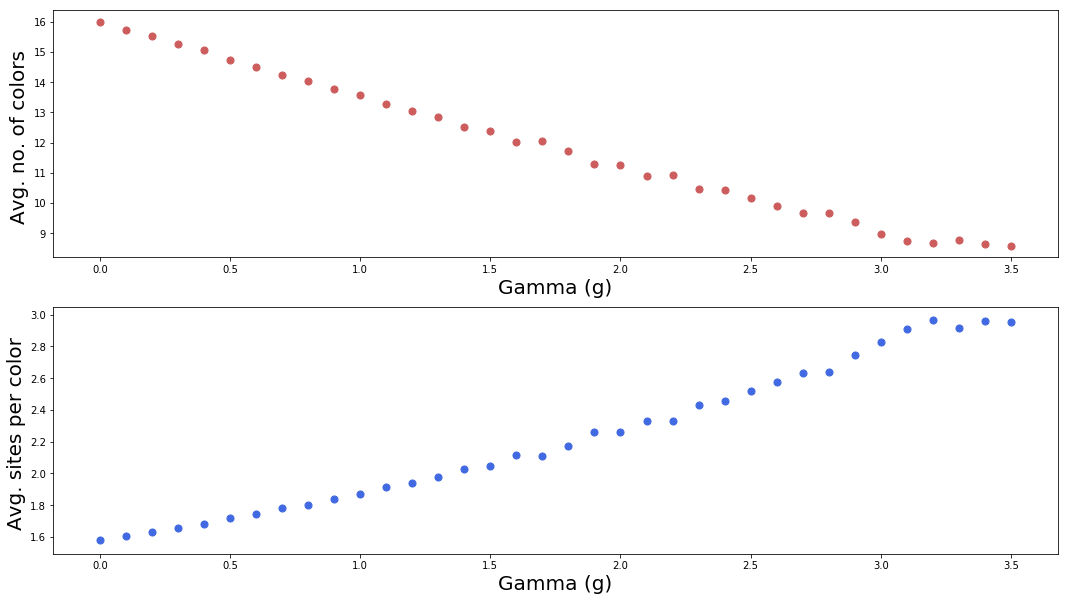

In [7]:
experiment_for_N (5,25) # Non-brute force